Here we run ordinary CNN model withotu data agumentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import seaborn as sn

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [4]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [5]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [6]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [7]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [8]:
trainData = torch.from_numpy(trainData).permute(0,3,1,2)
testData = torch.from_numpy(testData).permute(0,3,1,2)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [9]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [10]:
#Sette data til å vere dataloaders
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

In [11]:
from torchsummary import summary
import nnmodel

#Her måp det endres sidan den aksepterer ikek parametere gitt
model = nnmodel.ConvModel(0).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
            Conv2d-2           [-1, 64, 22, 22]           9,280
            Conv2d-3            [-1, 256, 9, 9]         147,712
            Linear-4                  [-1, 128]         295,040
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
           Dropout-7                    [-1, 2]               0
Total params: 452,738
Trainable params: 452,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.68
Params size (MB): 1.73
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


Trene modellen vår her, muligens implementere wandb her for å deploye modellen og se progressjonen og sammenligne med andre modeller samnt data agumentering kan komme med i denne delen av koden?

Running on the GPU
Epoch: 0/50
Train Loss: 0.7949, Train Accuracy: 63.82%
Test Loss: 0.4388, Test Accuracy: 82.00%
Epoch: 1/50
Train Loss: 0.4988, Train Accuracy: 73.46%
Test Loss: 0.3706, Test Accuracy: 83.77%
Epoch: 2/50
Train Loss: 0.4482, Train Accuracy: 76.83%
Test Loss: 0.3487, Test Accuracy: 85.93%
Epoch: 3/50
Train Loss: 0.4308, Train Accuracy: 77.22%
Test Loss: 0.3418, Test Accuracy: 86.75%
Epoch: 4/50
Train Loss: 0.4157, Train Accuracy: 77.81%
Test Loss: 0.3234, Test Accuracy: 86.32%
Epoch: 5/50
Train Loss: 0.4105, Train Accuracy: 77.90%
Test Loss: 0.3002, Test Accuracy: 88.27%
Epoch: 6/50
Train Loss: 0.3898, Train Accuracy: 78.97%
Test Loss: 0.3418, Test Accuracy: 84.63%
Epoch: 7/50
Train Loss: 0.3922, Train Accuracy: 79.01%
Test Loss: 0.3091, Test Accuracy: 87.80%
Epoch: 8/50
Train Loss: 0.3878, Train Accuracy: 78.88%
Test Loss: 0.2863, Test Accuracy: 87.97%
Epoch: 9/50
Train Loss: 0.3745, Train Accuracy: 79.50%
Test Loss: 0.2941, Test Accuracy: 87.43%
Epoch: 10/50
Train Lo

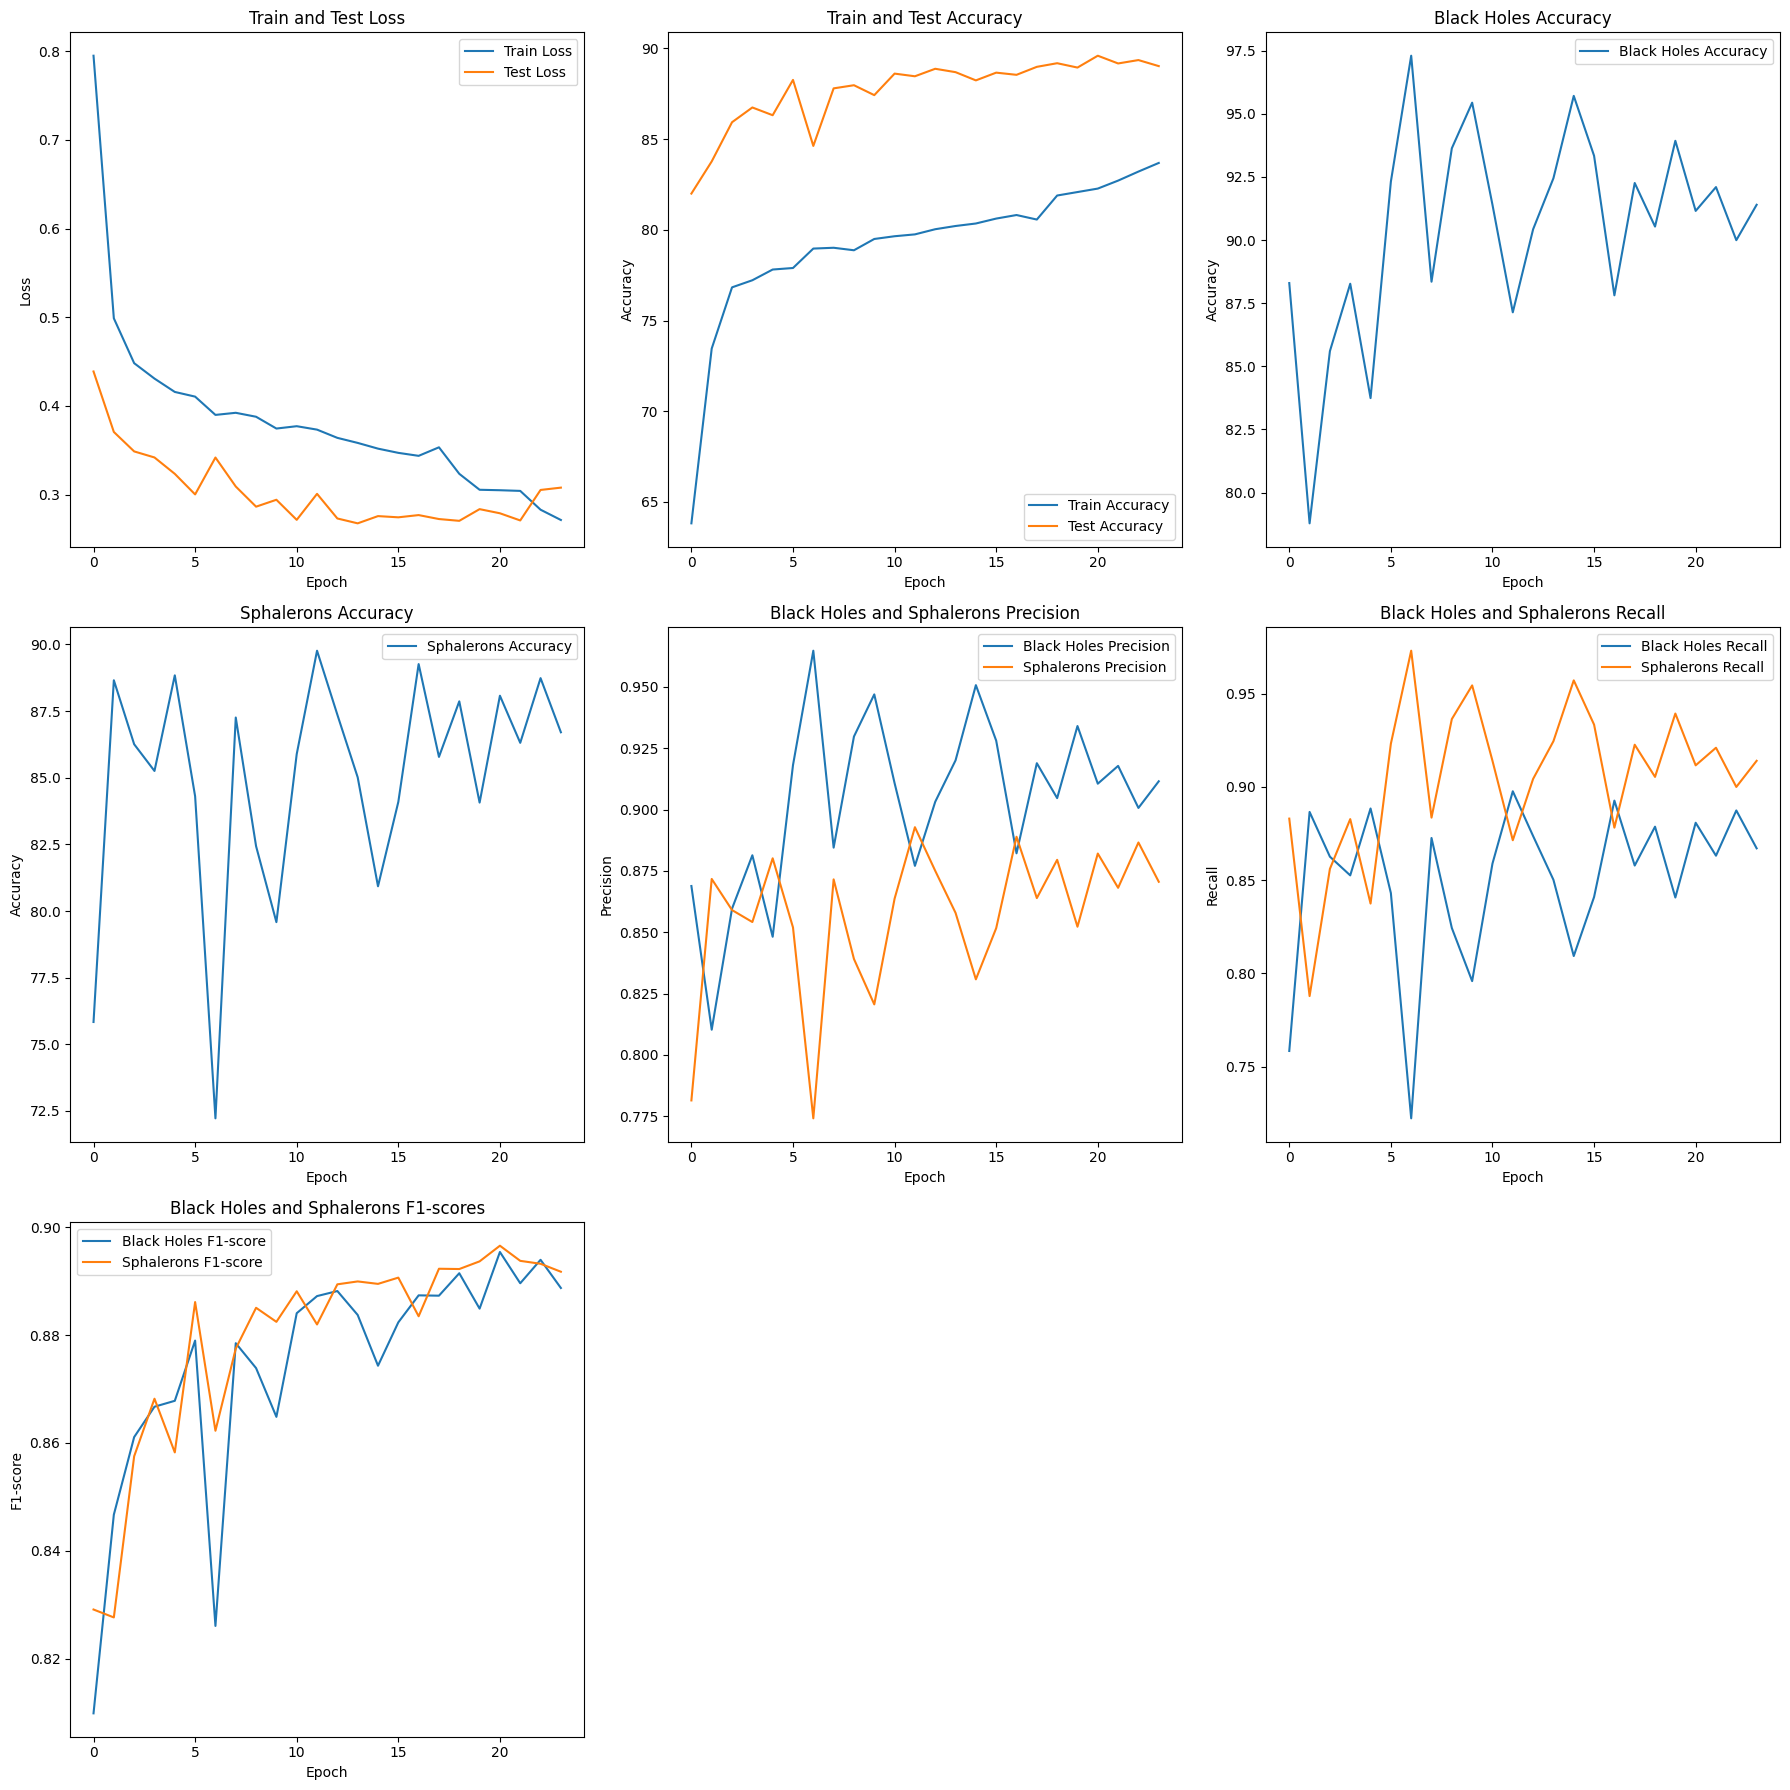

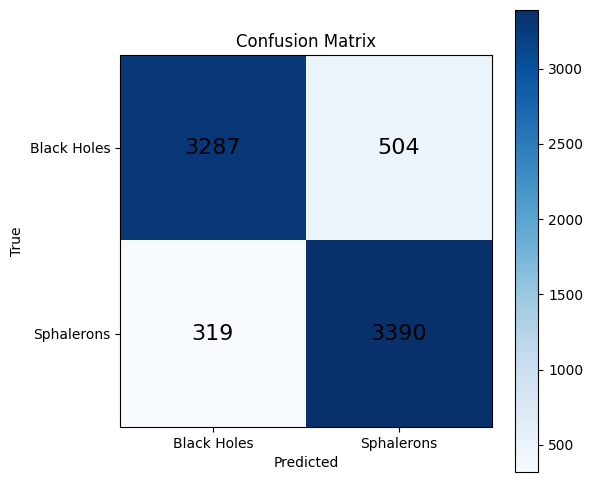

In [12]:
import trainer

model_save_path = "model_ConvModel.pth"

n_epochs = 50
model = nnmodel.ConvModel(0.5).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)

trainer.train(model, trainLoader, testLoader, optimizer, criterion, n_epochs, scheduler= scheduler, early_stopping_patience=10)

torch.save(model.state_dict(), model_save_path)